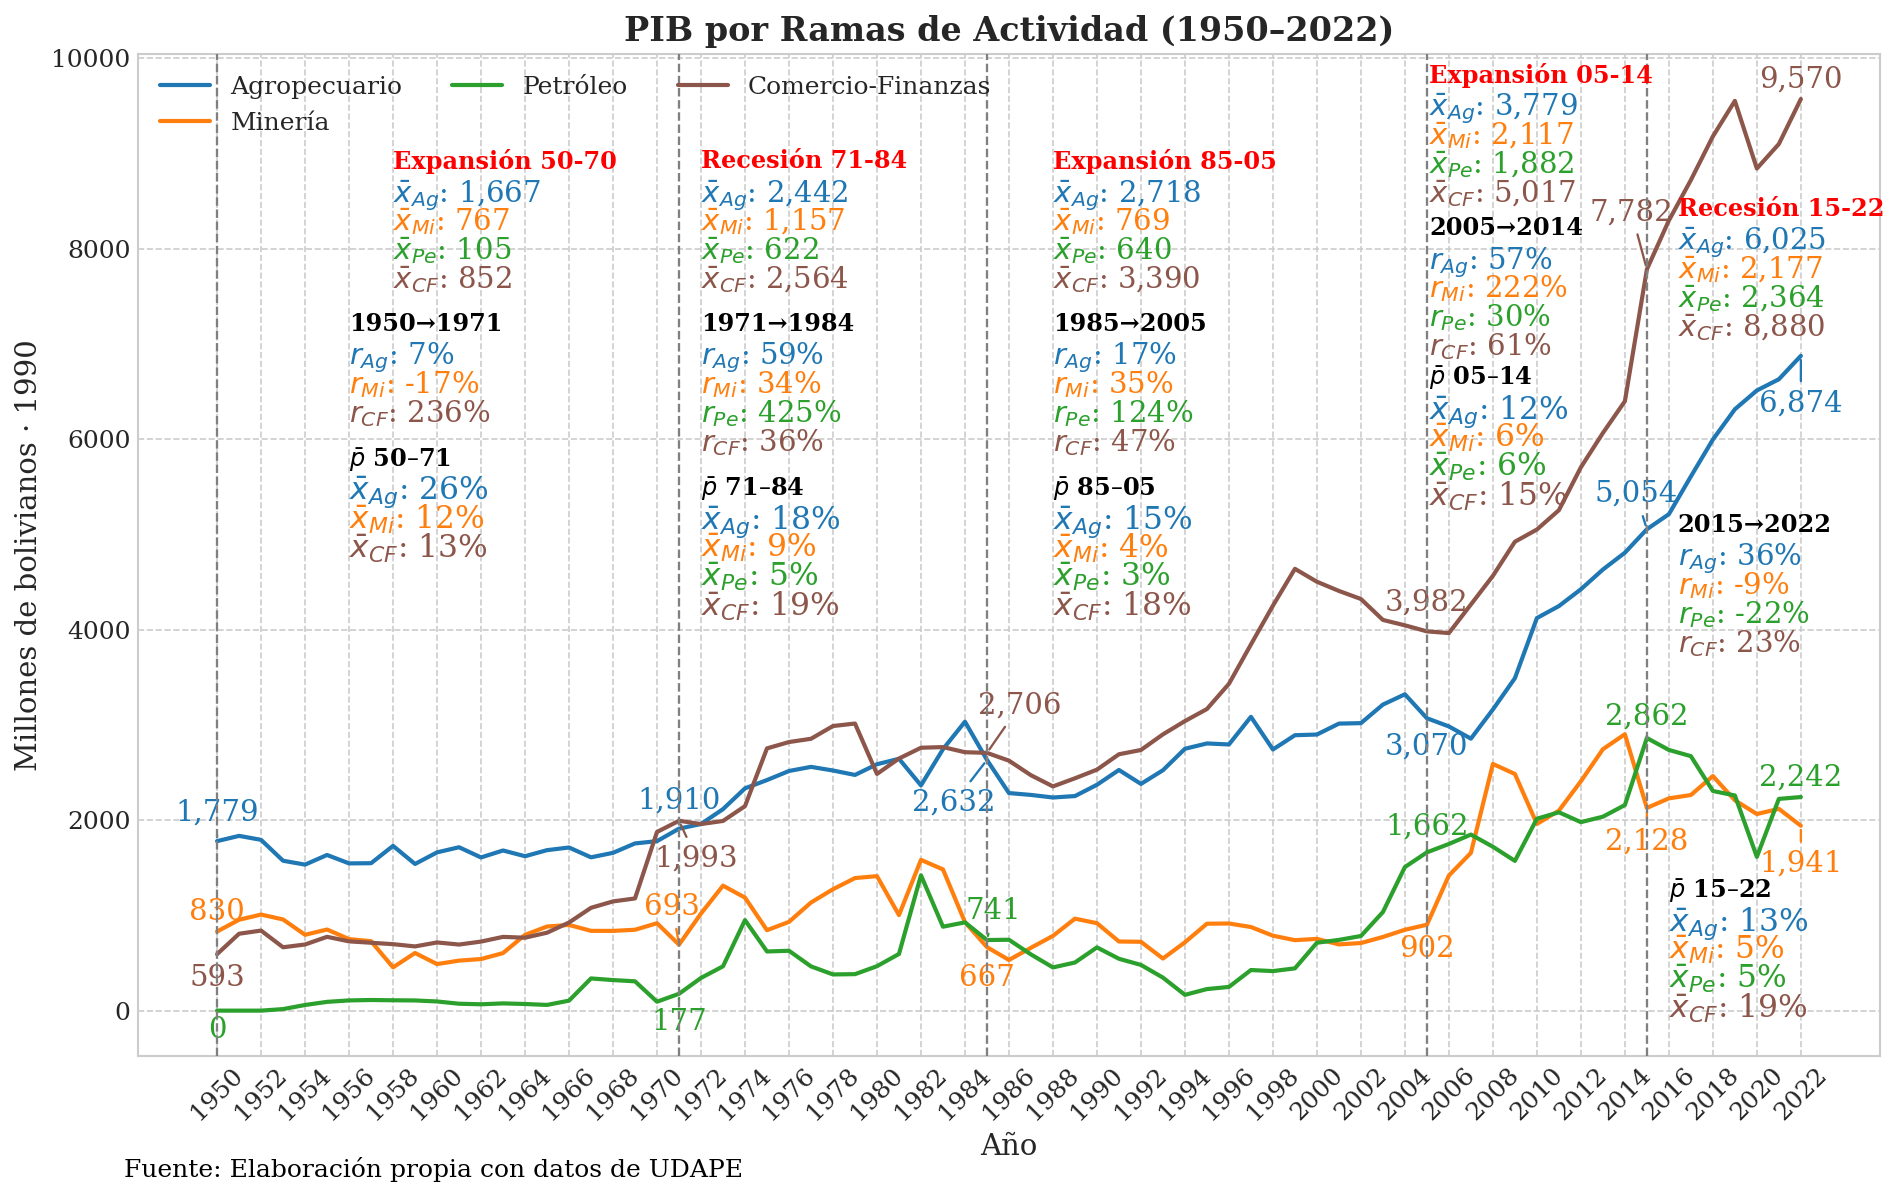

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os, sys
sys.path.append(os.path.abspath('../'))
from graficos_utils import *
from config import *



# ── 1. Configuración general ─────────────────────────────────────────
output_dir = "../../../../assets/tesis/serie_completa/pib"
os.makedirs(output_dir, exist_ok=True)

set_style()

# ── 2. Carga de datos ────────────────────────────────────────────────
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df = (pd.read_sql('SELECT * FROM pib_ramas', conn, index_col='año')
            .sort_index()) / 1000        # miles  → millones

sectores = [
    ("agropecuario",      "Agropecuario"),
    ("mineria",           "Minería"),
    ("petroleo",          "Petróleo"),
    ("comercio_finanzas", "Comercio-Finanzas"),
]
cols_sectores = [col for col, _ in sectores]
#estadisticas
CYCLES_SIN_CRISIS = adjust_cycles(df, CYCLES_SIN_CRISIS)
cycle_stats = {
    name: df.loc[period, cols_sectores].mean().to_dict()
    for name, period in CYCLES_SIN_CRISIS.items()
}
# ── 4. Hitos, años clave, offsets ────────────────────────────────────
hitos_v = {
    1950: "Expansion",
    1971: "Recesion",
    1985: "Expansion",
    2005: "Expansion",
    2015: "Recesion"
}

# añade (dx,dy) solo si quieres mover textos manualmente
annotation_offsets = {
    "agropecuario": {
        1950: (0, 300), 1971: (0, 300), 1985: (-1.5, -450),
        2005: (0, -300), 2015: (-0.5, 370),2022:(0,-500)
    },
    "mineria": {
        1950: (0, 200), 1971: (-0.3, 400), 1985: (0, -320),
        2005: (0, -250), 2015: (0, -350),2022:(0,-400)
    },
    "petroleo": {
        1950: (0, -200), 1971: (0, -300),1985: (0.3, 300),
        2005: (0, 270),
        2015: (0, 220),
        2022:(0,200)
    },
    "comercio_finanzas": {
        1950: (0, -250), 1971: (0.8, -400), 1985: (1.5, 500),
        2005: (0, 300),
        2015: (-0.7, 600),
        2022:(0,200)
    },
}
# hitos_offset: año → fracción de eje Y (0–1) donde apoya la base del recuadro
hitos_offset = {
    1950: 0.45, 1971: 0.50, 1985: 0.50,
    2005: 0.62, 2015: 0.48
}
text_offsets = {
    "Expansión 50-70": (1958,  0.90),
    "Recesión 71-84":  (1972,  0.90),
    "Expansión 85-05": (1988,  0.90),
    "Expansión 05-14": (2005.1,  0.99),
    "Recesión 15-22": (2016.4,  0.85),
}
period_offsets = {
    "1971-1984": (1972,  0.73),
    "1985-2005": (1988,  0.73),
    "2005-2014": (2005.1,  0.83),
    "2015-2022": (2016.4, 0.52),
}
participation_offsets = {
    "1950-1970": (1958, 0.56),
    "1971-1984": (1972, 0.56),
    "1985-2005": (1988, 0.56),
    "2005-2014": (2005.1, 0.675),
    "2015-2022": (2016, 0.14),
}
# ── 5. Gráfico ───────────────────────────────────────────────────────
custom_colors = {
    "agropecuario":      "#1f77b4",  # blue
    "mineria":           "#ff7f0e",  # orange
    "petroleo":          "#2ca02c",  # green
    "comercio_finanzas": "#8c564b",  # café
}

fig, ax = plt.subplots(figsize=(13,8))
for col, label in sectores:
    ax.plot(df.index, df[col],
            label=label,
            color=custom_colors[col])

# ── 6. Dibujar líneas verticales de hitos ───────────────────────────
add_hitos(ax, df.index, hitos_v_sin_crisis, hitos_offset)

# ── 7. Anotaciones de valores ────────────────────────────────────────
add_year_value_annotations(ax,df,annot_years_sin_crisis,cols_sectores,annotation_offsets, custom_colors)
        
# Mapa de tasas por año final
periodos = [
    (1971, 1984),
    (1985, 2005),
    (2005, 2014),
    (2015,2022)
]
componentes = ["agropecuario", "mineria", "comercio_finanzas", "petroleo"]

#cuadro de estadisticas
# 8.1 Abreviaturas para las ramas
abbr = {
    "agropecuario":      "Ag",
    "mineria":           "Mi",
    "petroleo":          "Pe",
    "comercio_finanzas": "CF",
}
# 8.3 Colores de cada rama (mismo diccionario de la línea)
component_colors = custom_colors
# calcula y_max DESPUÉS de haber dibujado las series
y_max = ax.get_ylim()[1]
line_spacing = y_max * 0.03          # 3 % de la altura

add_cycle_means_multi(
    ax,
    cycle_stats,
    text_offsets,
    abbr,
    component_colors,
    line_spacing=line_spacing,        # ← pasa el valor correcto
)


# 2. Parámetros de posición y estilo (sobre tu ax ya dibujado)
y_max       = ax.get_ylim()[1]
line_space  = y_max * 0.03
# abreviaturas para cada componente
abbr_comp   = {
    "agropecuario":      "Ag",
    "mineria":           "Mi",
    "comercio_finanzas": "CF",
    "petroleo":          "Pe",
}


# 4. Loop para anotar cada cuadro de tasas
add_period_growth_annotations_multi(
    ax,df,
    periodos,
    [col for col,_ in sectores],
    period_offsets,
    component_colors,
    abbr_comp,
)
periodos2=[
    (1950,1971)
]
period_offsets2={
    "1950-1971":(1956,0.73)
}
add_period_growth_annotations_multi(
    ax,df,
    periodos2,
    ["agropecuario", "mineria", "comercio_finanzas"],
    period_offsets2,
    component_colors,
    abbr_comp,
)

add_participation_cycle_boxes(
    ax,
    df,
    periodos,
    cols_sectores,
    "pib_real",
    participation_offsets, 
    abbr_comp, 
    component_colors
)

participation_offsets2={
    "1950-1971":(1956,0.59)
}
add_participation_cycle_boxes(
    ax,
    df,
    periodos2,
    ["agropecuario", "mineria", "comercio_finanzas"],
    "pib_real",
    participation_offsets2, 
    abbr_comp, 
    component_colors
)
# ── 8. Ajustes finales ───────────────────────────────────────────────
ax.set_title(f"PIB por Ramas de Actividad ({df.index[0]}–{df.index[-1]})",
             fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Millones de bolivianos · 1990")
ax.set_xticks(df.index[::max(1,len(df)//31)])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', ncol=3, fontsize=12)
# ── Pie de fuente ─────────────────────────────────────────────────────────
fig.text(
    0.07, 0.005,
    "Fuente: Elaboración propia con datos de UDAPE",
    ha="left", va="bottom",
    fontsize=12, color="black",
    transform=fig.transFigure
)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pib_rama_de_actividad_1.png"))
plt.show()

In [22]:
df.head(21)

,agropecuario,minas_canteras_total,mineria,petroleo,industria_manufacturera,construcciones,energia,transportes,comercio_finanzas,gobierno_general,propiedad_vivienda,servicios,derechos_imp,pib_nominal,pib_real
año,,,,,,,,,,,,,,,
1950,1779.438682,830.404718,830.404718,1.000000e-08,830.404718,118.629245,118.629245,355.887736,593.146227,355.887736,118.629245,355.887736,1.000000e-08,5456.945293,5456.945293
1951,1834.743891,954.066823,954.066823,1.000000e-08,880.677068,146.779511,73.389756,366.948778,807.287312,366.948778,146.779511,293.559023,1.000000e-08,5871.180450,5841.824548
1952,1793.084019,1008.609760,1008.609760,1.000000e-08,840.508134,168.101627,112.067751,392.237129,840.508134,336.203253,168.101627,336.203253,1.000000e-08,5995.624687,6018.038237
1953,1573.775398,973.469318,957.244830,1.622449e+01,811.224432,129.795909,81.122443,373.163239,665.204034,356.938750,178.469375,308.265284,1.000000e-08,5451.428184,5448.183286
1954,1532.891837,855.370583,796.087474,5.928311e+01,956.998771,127.035235,84.690157,431.919799,694.459285,423.450784,186.318345,271.008502,1.000000e-08,5564.143299,5561.602594
1955,1634.183143,943.683223,851.616568,9.206666e+01,1008.897105,168.788869,88.230545,487.186054,774.894354,341.413849,187.969423,222.494419,1.000000e-08,5857.740985,5856.590152
1956,1545.830297,858.353070,751.058936,1.072941e+02,931.869421,131.137275,85.437921,478.849745,727.215795,260.287621,188.758198,302.013117,1.000000e-08,5509.752459,5509.355073
1957,1547.722929,840.449544,728.869519,1.115800e+02,656.882406,147.573582,98.982280,410.326544,712.672419,374.332988,181.767460,356.336209,1.000000e-08,5327.046361,5326.326490
1958,1729.685017,563.040057,454.326271,1.087138e+02,718.809064,197.956447,84.374879,462.439240,697.715345,420.251801,189.843478,389.422518,1.000000e-08,5453.537845,5453.537845


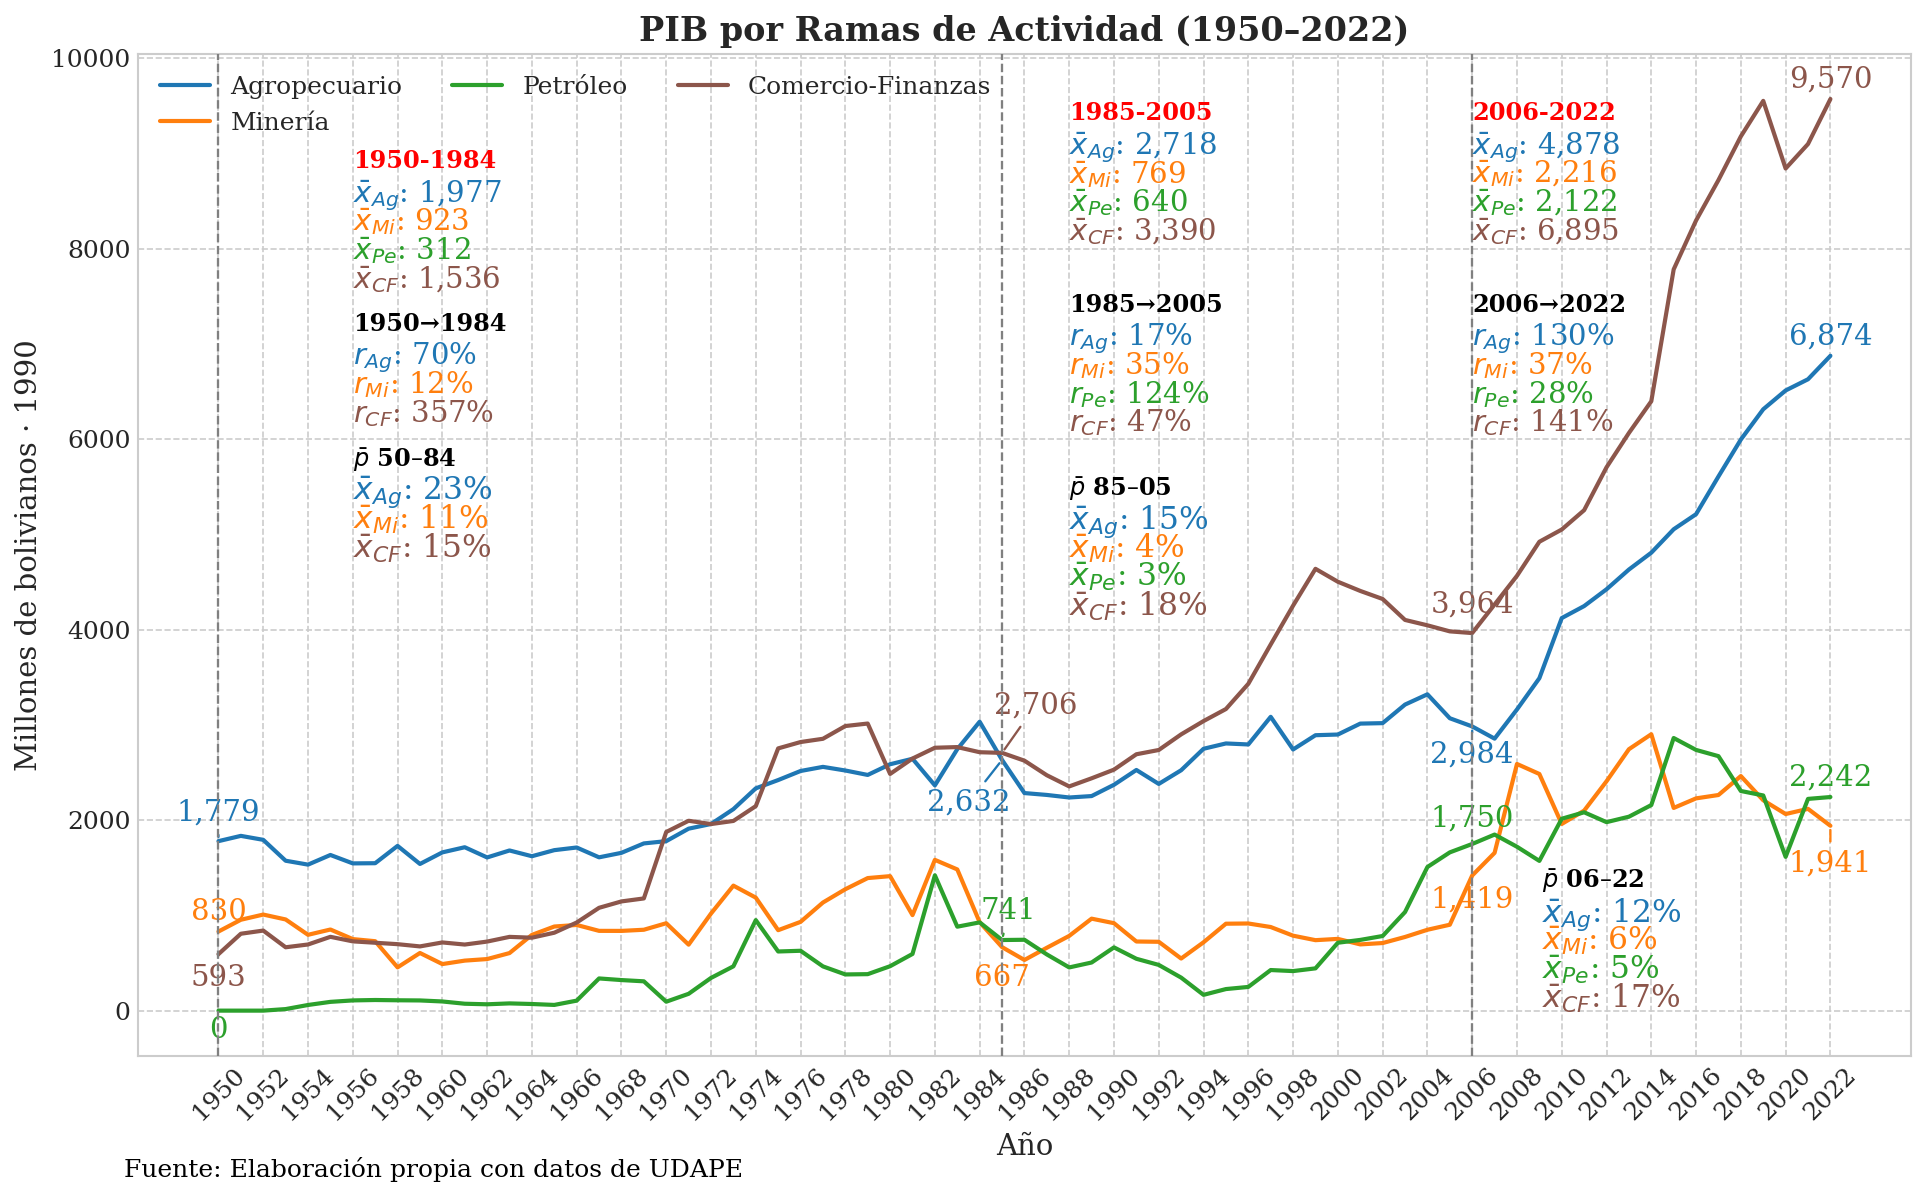

In [18]:

sectores = [
    ("agropecuario",      "Agropecuario"),
    ("mineria",           "Minería"),
    ("petroleo",          "Petróleo"),
    ("comercio_finanzas", "Comercio-Finanzas"),
]
cols_sectores = [col for col, _ in sectores]
#estadisticas
cycle_stats = {
    name: df.loc[period, cols_sectores].mean().to_dict()
    for name, period in CYCLES_PERIODOS.items()
}



anot_years = [1950,1985,2006,2022]

# añade (dx,dy) solo si quieres mover textos manualmente
annotation_offsets = {
    "agropecuario": {
        1950: (0, 300), 1985: (-1.5, -450),
        2006: (0, -300), 2022:(0,200)
    },
    "mineria": {
        1950: (0, 200), 1985: (0, -320),
        2006: (0, -250), 2022:(0,-400)
    },
    "petroleo": {
        1950: (0, -200), 1985: (0.3, 300),
        2006: (0, 270),
        2022:(0,200)
    },
    "comercio_finanzas": {
        1950: (0, -250), 1985: (1.5, 500),
        2006: (0, 300),
        2022:(0,200)
    },
}
period_offsets = {
    "1950-1984": (1956,  0.60),
    "1985-2005": (1988,  0.75),
    "2006-2022": (2006,  0.75),
}
text_offsets = {
    "1950-1984": (1956,  0.90),
    "1985-2005":  (1988,  0.95),
    "2006-2022": (2006,  0.95),

}
# hitos_offset: año → fracción de eje Y (0–1) donde apoya la base del recuadro
hitos_offset = {
    1950: 0.45, 1985: 0.50, 2006: 0.50,
}
participation_offsets = {
    "1985-2005": (1988, 0.56),
    "2006-2022": (2009.1, 0.15),
}
# ── 5. Gráfico ───────────────────────────────────────────────────────
custom_colors = {
    "agropecuario":      "#1f77b4",  # blue
    "mineria":           "#ff7f0e",  # orange
    "petroleo":          "#2ca02c",  # green
    "comercio_finanzas": "#8c564b",  # café
}

fig, ax = plt.subplots(figsize=(13,8))
for col, label in sectores:
    ax.plot(df.index, df[col],
            label=label,
            color=custom_colors[col])

# ── 6. Dibujar líneas verticales de hitos ───────────────────────────


# ── 7. Anotaciones de valores ────────────────────────────────────────
add_hitos(ax, df.index, hitos_v_periodos, hitos_offset)
add_year_value_annotations(ax,df,annot_years_periodos,cols_sectores,annotation_offsets, custom_colors)
# Mapa de tasas por año final
periodos = [
    (1985, 2005),
    (2006, 2022)
]
componentes = ["agropecuario", "mineria", "comercio_finanzas", "petroleo"]



#cuadro de estadisticas
# 8.1 Abreviaturas para las ramas
abbr = {
    "agropecuario":      "Ag",
    "mineria":           "Mi",
    "petroleo":          "Pe",
    "comercio_finanzas": "CF",
}



# 8.3 Colores de cada rama (mismo diccionario de la línea)
component_colors = custom_colors


# calcula y_max DESPUÉS de haber dibujado las series
y_max = ax.get_ylim()[1]
line_spacing = y_max * 0.03          # 3 % de la altura

add_cycle_means_multi(
    ax,
    cycle_stats,
    text_offsets,
    abbr,
    component_colors,
    line_spacing=line_spacing,        # ← pasa el valor correcto
)


# 2. Parámetros de posición y estilo (sobre tu ax ya dibujado)
y_max       = ax.get_ylim()[1]
line_space  = y_max * 0.03
# abreviaturas para cada componente
abbr_comp   = {
    "agropecuario":      "Ag",
    "mineria":           "Mi",
    "comercio_finanzas": "CF",
    "petroleo":          "Pe",
}


# 4. Loop para anotar cada cuadro de tasas
add_period_growth_annotations_multi(
    ax,df,
    periodos,
    [col for col,_ in sectores],
    period_offsets,
    component_colors,
    abbr_comp,
)
periodos2=[
    (1950,1984)
]
period_offsets2={
    "1950-1984":(1956,0.73)
}
add_period_growth_annotations_multi(
    ax,df,
    periodos2,
    ["agropecuario", "mineria", "comercio_finanzas"],
    period_offsets2,
    component_colors,
    abbr_comp,
)

add_participation_cycle_boxes(
    ax,
    df,
    periodos,
    cols_sectores,
    "pib_real",
    participation_offsets, 
    abbr_comp, 
    component_colors
)
participation_offsets2={
    "1950-1984":(1956,0.59)
}
add_participation_cycle_boxes(
    ax,
    df,
    periodos2,
    ["agropecuario", "mineria", "comercio_finanzas"],
    "pib_real",
    participation_offsets2, 
    abbr_comp, 
    component_colors
)
# ── 8. Ajustes finales ───────────────────────────────────────────────
ax.set_title(f"PIB por Ramas de Actividad ({df.index[0]}–{df.index[-1]})",
             fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Millones de bolivianos · 1990")
ax.set_xticks(df.index[::max(1,len(df)//31)])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', ncol=3, fontsize=12)
# ── Pie de fuente ─────────────────────────────────────────────────────────
fig.text(
    0.07, 0.005,
    "Fuente: Elaboración propia con datos de UDAPE",
    ha="left", va="bottom",
    fontsize=12, color="black",
    transform=fig.transFigure
)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pib_rama_de_actividad_2.png"))
plt.show()